# Freespace

In [38]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from IPython import display
import time
import imageio
import pylab
import matplotlib.patches as patches
import datetime 

from data_processing_helpers import get_positions, get_position, get_pixels_from_world, in_collision, hit_obstacle

obs_len = 8
pred_len = 12
seq_len = obs_len + pred_len

In [2]:
root = '/home/q392358/Documents/FLORA/data/TRAJNET/trajnet/Training/'
dataset_paths = [root + "train/", root + "test/"]
frame_rate = 30

# Read all scene annotations and store them in a unique dataframe 
# Each row will have this format: [scene_name, frameID, agentID, x, y, lost, occluded, interpolated, agent_type]
scenes_annotations_dataframe = pd.DataFrame(columns=["scene_name", "video_name", "frameID", "agentID", "x", "y"],
                                            dtype=np.float64)

for dataset_path in dataset_paths:
    for root, dirs, files in os.walk(dataset_path):
        if root != dataset_path:
            break;
        for file_name in files:
            scene_dataframe = pd.read_csv(root + "/" + file_name, sep=' ', header=None, 
                                 names=["frameID", "agentID", "x", "y"])
            scene_dataframe["scene_name"] = file_name.split("_")[0]
            scene_dataframe["video_name"] = file_name[:-4]
            scenes_annotations_dataframe = scenes_annotations_dataframe.append(scene_dataframe)

scenes_annotations_dataframe = scenes_annotations_dataframe.sort_values(['video_name', 'scene_name', 'frameID', 'agentID'])
scenes_annotations_dataframe.head()

/home/q392358/.local/share/virtualenvs/safe_gan/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,agentID,frameID,scene_name,video_name,x,y
0,100.0,0.0,bookstore,bookstore_0,1.73,14.39
20,129.0,0.0,bookstore,bookstore_0,7.13,-13.86
40,139.0,0.0,bookstore,bookstore_0,-11.63,18.01
60,194.0,0.0,bookstore,bookstore_0,-10.90,19.43
80,212.0,0.0,bookstore,bookstore_0,-4.33,17.57


Select a threshold and get locations that do not collide.

In [3]:
videos = scenes_annotations_dataframe["video_name"].unique()

threshold = 1.0
free_space_frames_per_video = {}

for video in videos:
    scene_annotations_dataframe = scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video]
    frames = scene_annotations_dataframe.frameID.unique()
    
    path = '/home/q392358/Documents/FLORA/data/SDD/{}'.format(video)
    occupancy_map = np.load(path + '/world_points_boundary.npy')
    
    free_space_frames = []
    for frame in frames:
        current_frame = scene_annotations_dataframe[scene_annotations_dataframe.frameID == frame]
        if len(in_collision(current_frame, threshold)) > 0:
            continue
        
        if len(hit_obstacle(current_frame, occupancy_map, threshold)) > 0:
            continue
        
        free_space_frames.append(frame)
    
    free_space_frames_per_video[video] = free_space_frames

## Get contiguous sequence

Get locations that appear in succeeding frames.

Get a sequence of at least 20 frames and convert to dataframe.

In [45]:
import more_itertools as mit
from functools import reduce

freespace_scenes_dataframe = pd.DataFrame(columns=["agentID", "frameID", "scene_name", "video_name","x", "y"],
                                            dtype=np.float64)

for video in free_space_frames_per_video.keys():
    if len(free_space_frames_per_video[video]) < seq_len:
        continue
    
    # Filter consecutive frames that are in free space
    frame_list = [frame // 12 for frame in free_space_frames_per_video[video]]
    sub_sequences = [list(group) for group in mit.consecutive_groups(frame_list)]
    
    # Remove short sequences
    sub_sequences = [seq for seq in sub_sequences if len(seq) >= seq_len]
    
    if len(sub_sequences) < 1:
        continue
            
    # Get back sample rate
    sub_sequences = [x*12 for b in sub_sequences for x in b]
    
    # Get sequences with same agent    
    rows = scenes_annotations_dataframe[(scenes_annotations_dataframe.frameID.isin(sub_sequences)) & (scenes_annotations_dataframe.video_name == video)]
    frames = rows.frameID.unique()
    for start_frame in frames[:-seq_len]:
        seq_frames = [start_frame + i*12 for i in range(seq_len)]
                
        # Only append df if same agent appears in full seq
        for agent in rows.agentID.unique():
            agent_frame_row = rows[(rows.frameID.isin(seq_frames)) & (rows.agentID == agent)]
            if len(agent_frame_row) == seq_len:
                freespace_scenes_dataframe = freespace_scenes_dataframe.append(agent_frame_row)

freespace_scenes_dataframe.head(seq_len)

,agentID,frameID,scene_name,video_name,x,y
3180,148.0,4080.0,bookstore,bookstore_1,-1.23,-7.16
3181,148.0,4092.0,bookstore,bookstore_1,-1.23,-7.16
3182,148.0,4104.0,bookstore,bookstore_1,-1.23,-7.16
3183,148.0,4116.0,bookstore,bookstore_1,-1.23,-7.16
3184,148.0,4128.0,bookstore,bookstore_1,-1.23,-7.16


## Visualize

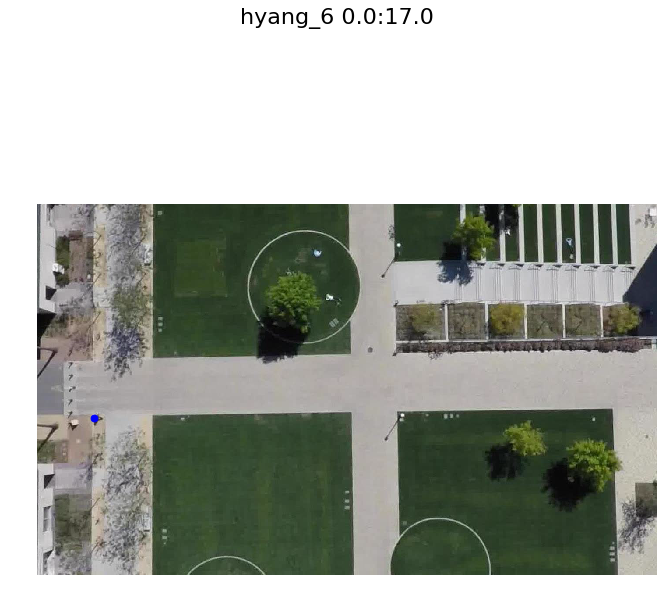

## Predict 

Convert sequence to input (displacements trajectory). 

Load model and predict.

Visualize. 

In [ ]:
import torch
import os 
import sys
from attrdict import AttrDict

sys.path.append(os.path.join("/home/q392358", "Documents", "FLORA"))
#dir_path = os.path.dirname(os.getcwd())
#sys.path.append(os.path.join(dir_path, "..", ".."))

from scripts.helpers.helper_get_generator import get_generator

model1 = torch.load('../../results/models/TRAJNET/SafeGAN_DP/checkpoint_200_with_model.pt')
model2 = torch.load('../../results/models/TRAJNET/SafeGAN/checkpoint_200_with_model.pt')

generator1 = get_generator(model1, AttrDict(model1.args))
generator2 = get_generator(model2, AttrDict(model2.args))

In [26]:
for video in freespace_scenes_dataframe.video_name.unique():
    dataframe_current_video = freespace_scenes_dataframe[freespace_scenes_dataframe.video_name == video]
    
    xy = np.transpose(np.stack([dataframe_current_video.x, dataframe_current_video.y]))
    
    for i in range(0, len(xy)-seq_len):
        tot_seq = xy[i:i+seq_len]
        tot_disp_seq = np.zeros_like(tot_seq)
        tot_disp_seq[1:] = tot_seq[1:] - tot_seq[:-1]
        
        obs_disp_seq = tot_disp_seq[:obs_len]   

bookstore_1


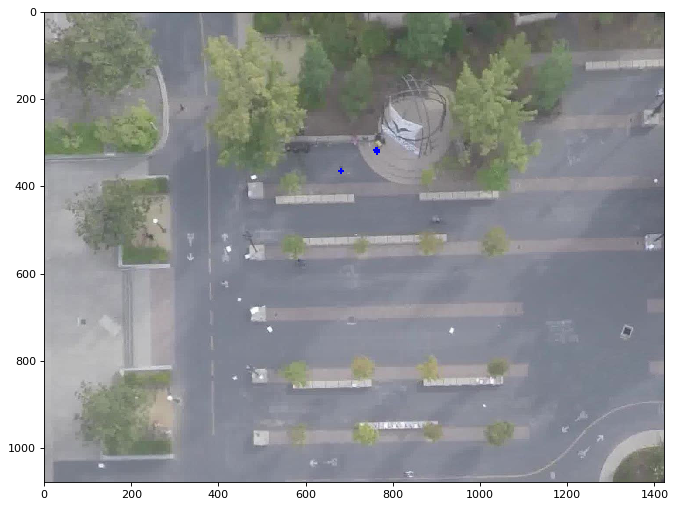

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

for video in freespace_scenes_dataframe.video_name.unique():
    print(video)
    dataframe_current_video = freespace_scenes_dataframe[freespace_scenes_dataframe.video_name == video]
    
    frames = dataframe_current_video.frameID.unique()
    
    video_num = video[-1]
    scene_name = video[:-2] 
    
    # Homography matrix
    path = '/home/q392358/Documents/FLORA/data/SDD/{}'.format(video)
    h_matrix = pd.read_csv(path + '/{}_homography.txt'.format(video), delim_whitespace=True, header=None).values
    
    # Video reader
    filename = '/media/q392358/ba2b8f54-91f6-4e35-8323-e164edb98d11/stanford_campus_dataset/videos/{}/video{}/video.mov'.format(scene_name, video_num)
    vid = imageio.get_reader(filename,  'ffmpeg')
       
    #obstacles = get_pixels_from_world(occupancy_map, h_matrix)
    xy = np.transpose(np.stack([dataframe_current_video.x, dataframe_current_video.y]))
    
    # Loop over sequences
    for i in range(0, len(frames)-seq_len):
        start = i
        end = i+seq_len

        tot_seq = xy[start:end]
        tot_disp_seq = np.zeros_like(tot_seq)
        tot_disp_seq[1:] = tot_seq[1:] - tot_seq[:-1]
        
        obs_disp_seq = tot_disp_seq[:obs_len]
        start_frame = frames[start]
        image = vid.get_data(int(start_frame))
        ax.imshow(image)
        
        obs_pixels = get_pixels_from_world(xy[start:start+obs_len], h_matrix)      
        ax.scatter(obs_pixels[:, 0], obs_pixels[:, 1], color='blue', marker='+')
        
        
    
    break
    # Loop over seq
    for j in range(obs_len, seq_len):
        frame = start_frame + j
        current_frame = dataframe_current_video[dataframe_current_video.frameID == frame]
        xy = np.transpose(np.stack([current_frame.x, current_frame.y]))
        pixels = get_pixels_from_world(xy, h_matrix)
        
        image = vid.get_data(int(frame))
        fig = pylab.figure(1)

        m, s = divmod(frame//frame_rate, 60)
        fig.suptitle('{} {}:{}'.format(video, m, s), fontsize=20)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        ax.clear()
        ax.imshow(image)
        current_index = i*seq_len + j
        ax.scatter(pixels[:, 0], pixels[:, 1], color='blue')

        ax.axis('off')
        time.sleep(0.1)
    
pylab.show()

# Pedestrian interactions

In [ ]:
## 

# Scene interactions

In [ ]:
neighborhood_size=0.9
grid_side_size=3
def make_grid(ped_pos, other_pos):
    top_left_x = ped_pos[:, 0] - neighborhood_size / 2
    top_left_y = ped_pos[:, 1] + neighborhood_size / 2
    top_left = np.transpose(np.stack([top_left_x, top_left_y]))
    
    bottom_right_x = ped_pos[:, 0] + neighborhood_size / 2
    bottom_right_y = ped_pos[:, 1] - neighborhood_size / 2
    bottom_right = np.transpose(np.stack([bottom_right_x, bottom_right_y]))
    
    x_bound = ((other_pos[:, 0] >= bottom_right[:, 0]) +
               (other_pos[:, 0] <= top_left[:, 0]))
    y_bound = ((other_pos[:, 1] >= top_left[:, 1]) +
               (other_pos[:, 1] <= bottom_right[:, 1]))
    
    cell_x = np.floor(
        ((other_pos[:, 0] - top_left[:, 0]) / neighborhood_size) *
        grid_side_size)
    cell_y = np.floor(
        ((top_left[:, 1] - other_pos[:, 1]) / neighborhood_size) *
        grid_side_size)
    grid_pos = cell_x + cell_y * grid_side_size
    
    grid_pos += 1
    within_bound = x_bound + y_bound
    num_ped = other_pos.shape[0]
    #within_bound[0::num_ped + 1] = 1  # Don't include the ped itself
    grid_pos[within_bound != 0] = 0
    return grid_pos

In [ ]:
import matplotlib.patches as patches

def draw_scene(ids, ped_pos, other_pos):
    ax = plt.gca()
    for i, pid in enumerate(ids):
        ax.text(other_pos[i, 0], other_pos[i, 1], pid)
    ax.scatter(other_pos[:, 0], other_pos[:, 1])
    ax.scatter(ped_pos[:, 0], ped_pos[:, 1], c='r')
    ax.axis('equal')
    
def draw_grid(ids, ped_pos):
    fig,ax = plt.subplots(1)
    ax = plt.gca()
    ax.cla()
    grid = patches.Rectangle((ped_pos[:, 0]-neighborhood_size/2, ped_pos[:, 1]-neighborhood_size/2),neighborhood_size,neighborhood_size,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(grid)
    
draw_grid(ped=ped)   
#draw_scene(current_frame, ped=ped)


In [ ]:
def in_collision(ped, grid):
    copy_grid = grid.copy()
    myGridCell = grid[ped]    
    copy_grid[ped] = 0

    if any(copy_grid == myGridCell):
        return True
    else:
        return False

In [ ]:

collisioin_freq = []
threshold = [0.1, 0.2, 0.3]
for minimum_distance in threshold:
    collisions = 0
    for frame in frames:
        current_frame = scene_annotations_dataframe[scene_annotations_dataframe.frameID == frame]
        other_pos = get_positions(current_frame)
    
        for i, p1 in enumerate(other_pos):
            for j, p2 in enumerate(other_pos[i+1:]):
                if np.linalg.norm(p1-p2) <= minimum_distance:
                    collisions += 1
                    #print('frame {} contains {} peds'.format(frame, len(current_frame)))
        '''
        ids = current_frame.agentID
        for i, pid in enumerate(ids):
            ped_pos = get_position(current_frame, pid)
            grid = make_grid(ped_pos, other_pos)
            if False: #in_collision(i, grid):
                print('frame {} ped {} grid {}'.format(frame, pid, grid))
                draw_grid(ids, ped_pos)
                draw_scene(ids, ped_pos, other_pos)
                ax = plt.gca()
                ax.set_xlabel('frame : {0} ped : {1} grid : {2}'.format(current_frame.frameID.unique()[0], pid, grid))
        '''
    collisioin_freq.append(collisions)
    print('collisions {} out of {} frames = {} for {} m'.format(collisions, len(frames), collisions/len(frames), minimum_distance))
    
print(collisioin_freq)